# **AI 기반 경구약제 객체 탐지**

## **1. 프로젝트 개요**

### **1.1 문제 정의 및 목표**
- 스마트폰으로 촬영된 알약 이미지에서 약의 종류(Class)와 위치(Bounding Box)를 동시에 탐지하는 모델 개발.
- Kaggle 데이터(AI Hub 원천) 구조 파악 및 학습 파이프라인 구축
- 알약 객체 탐지 및 30종 상비약 서비스 정보 매핑

### **1.2 데이터셋 소개**
- Ai hub 경구약제 이미지 데이터를 가공한 데이터 (COCO Format JSON + Images)

## **2. 환경 설정 및 데이터 준비**

### **2.1 라이브러리 로드 & 장치(GPU) 설정**

In [30]:
import os
import random
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current Device: {device}")

# 한글 폰트(나눔글꼴) 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Seed set to 42
Current Device: cpu
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory 

### **2.2 데이터 다운로드**

In [ ]:
from google.colab import files

# 1. 기존 파일 삭제 (꼬임 방지)
!rm -f kaggle.json
!rm -rf ~/.kaggle

print("'kaggle.json'을 선택해주세요!")
uploaded = files.upload() # <--- 여기서 파일 선택 창이 뜹니다!

# 2. 파일 이동 및 권한 설정
if 'kaggle.json' in uploaded.keys():
    print("✅ 파일 업로드 성공! 인증을 진행합니다.")
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # 3. 다운로드 및 압축 해제
    if not os.path.exists('./ai06-level1-project.zip'):
        print("🚀 데이터 다운로드 시작...")
        !kaggle competitions download -c ai06-level1-project

        print("📂 압축 해제 중...")
        !unzip -q ai06-level1-project.zip -d ./data
        print("🎉 데이터 준비 완료! (./data 폴더)")
    else:
        print("이미 다운로드된 데이터가 있습니다.")
else:
    print("❌ 파일 업로드가 취소되었습니다.")

### **2.3 구글 드라이브 마운트 및 백업**

In [12]:
from google.colab import drive
import shutil
import os

# 1. 구글 드라이브 연결 (로그인 창이 뜨면 승인해주세요)
print("📥 구글 드라이브를 연결합니다...")
drive.mount('/content/drive')
MY_BACKUP_FOLDER = "/content/drive/MyDrive/My_AI_Project/team_project"

# 2. 백업 실행
zip_file = './ai06-level1-project.zip'

if os.path.exists(MY_BACKUP_FOLDER):
    if os.path.exists(zip_file):
        print(f"🚀 드라이브로 복사 시작... (약 1~2분 소요)")
        print(f"Source: {zip_file}")
        print(f"Target: {MY_BACKUP_FOLDER}")

        # 파일 복사
        shutil.copy(zip_file, MY_BACKUP_FOLDER)

        print("✅ 백업 완료! 이제 데이터가 드라이브에 안전하게 저장되었습니다.")
    else:
        print("⚠️ 복사할 ZIP 파일이 없습니다. (이미 압축 풀고 원본을 지우셨나요?)")
else:
    print(f"❌ 폴더를 찾을 수 없습니다: {MY_BACKUP_FOLDER}")
    print("경로에 오타가 없는지, 마운트가 잘 되었는지 확인해주세요.")

📥 구글 드라이브를 연결합니다...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 드라이브로 복사 시작... (약 1~2분 소요)
Source: ./ai06-level1-project.zip
Target: /content/drive/MyDrive/My_AI_Project/team_project
✅ 백업 완료! 이제 데이터가 드라이브에 안전하게 저장되었습니다.


### **2.4 분산된 JSON 병합**
- 원본 데이터가 수백 개의 폴더와 파일로 쪼개져 있어 학습 불가
- 해결: 스크립트로 하나로 합쳐서 train.json 생성

In [17]:
import os
import json
import glob
from tqdm import tqdm

# 1. 경로 설정
# Config 클래스에 있는 경로를 그대로 씁니다.
ANNOTATION_ROOT = os.path.join(Config.DATA_ROOT, 'train_annotations')
OUTPUT_JSON = os.path.join(Config.DATA_ROOT, 'train.json')  # 루트에 바로 저장

print(f"📂 검색 경로: {ANNOTATION_ROOT}")

# 2. 흩어진 모든 .json 파일 찾기 (재귀 탐색)
# 폴더 깊숙이 있는 것까지 다 찾아냅니다.
json_files = glob.glob(os.path.join(ANNOTATION_ROOT, '**', '*.json'), recursive=True)
print(f"🔍 발견된 JSON 파일 개수: {len(json_files)}개")

# 3. 데이터 병합 (Merging)
merged_data = {
    "images": [],
    "annotations": [],
    "categories": []
}

# 카테고리 중복 방지용 Set
seen_category_ids = set()
# 이미지 ID 중복 방지용 (혹시 몰라서)
seen_image_ids = set()

print("🚀 병합 시작...")

for json_path in tqdm(json_files):
    with open(json_path, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)

            # (1) Images 병합
            for img in data.get('images', []):
                if img['id'] not in seen_image_ids:
                    merged_data['images'].append(img)
                    seen_image_ids.add(img['id'])

            # (2) Annotations 병합
            if 'annotations' in data:
                merged_data['annotations'].extend(data['annotations'])

            # (3) Categories 병합
            for cat in data.get('categories', []):
                if cat['id'] not in seen_category_ids:
                    merged_data['categories'].append(cat)
                    seen_category_ids.add(cat['id'])

        except json.JSONDecodeError:
            print(f"⚠️ 에러: 깨진 파일 건너뜀 - {json_path}")

# 4. 결과 저장
with open(OUTPUT_JSON, 'w', encoding='utf-8') as f:
    json.dump(merged_data, f, ensure_ascii=False)

# 5. Config 경로 업데이트 (이제 이 파일을 씁니다!)
Config.TRAIN_JSON = OUTPUT_JSON

print("-" * 30)
print(f"🎉 병합 완료!")
print(f"💾 저장 위치: {OUTPUT_JSON}")
print(f"- 총 이미지: {len(merged_data['images'])}")
print(f"- 총 박스(Annotations): {len(merged_data['annotations'])}")
print(f"- 총 알약 종류(Categories): {len(merged_data['categories'])}")
print("-" * 30)

📂 검색 경로: ./data/train_annotations
🔍 발견된 JSON 파일 개수: 1001개
🚀 병합 시작...


100%|██████████| 1001/1001 [00:00<00:00, 2869.46it/s]


------------------------------
🎉 병합 완료!
💾 저장 위치: ./data/train.json
📊 총 이미지: 369
📊 총 박스(Annotations): 1001
📊 총 알약 종류(Categories): 56
------------------------------


### **2.5 경로 및 하이퍼파라미터 설정**

In [11]:
class Config:
    # 1. 데이터 경로
    DATA_ROOT = './data'
    TRAIN_IMG_DIR = os.path.join(DATA_ROOT, 'train_images')
    TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test_images')

    # 경로 지정
    TRAIN_JSON = os.path.join(DATA_ROOT, 'train.json')

    # 2. 하이퍼파라미터
    IMG_SIZE = 224
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 20
    NUM_WORKERS = 2

# 확인
if os.path.exists(Config.TRAIN_JSON):
    print(f"✅ Config 확정! 학습 데이터 경로: {Config.TRAIN_JSON}")
else:
    print("❌ 파일을 찾을 수 없습니다. 2.4 단계를 다시 확인하세요.")

✅ Config 확정! 학습 데이터 경로: ./data/train.json


### **2.6 데이터 연결 검증**

🕵️ 데이터 연결 테스트 중... (./data/train.json)
✅ 연결 성공! 파일명: K-003351-013900-021325_0_2_0_2_75_000_200.png
💊 알약 개수: 3개


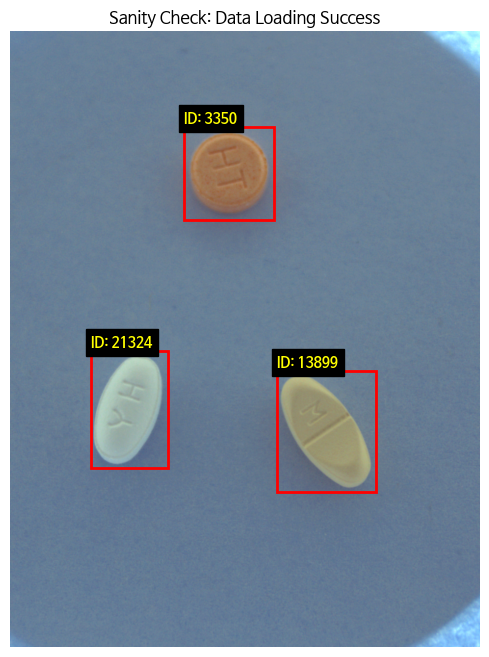

In [12]:
import matplotlib.patches as patches

def check_data_connection(json_path, img_dir):
    print(f"🕵️ 데이터 연결 테스트 중... ({json_path})")

    # 1. JSON 로드
    if not os.path.exists(json_path):
        print("❌ JSON 파일이 없습니다!")
        return

    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 2. 랜덤으로 이미지 하나 선택
    import random
    if not data['images']:
        print("❌ JSON에 이미지 정보가 없습니다.")
        return

    img_info = random.choice(data['images'])
    file_name = img_info['file_name']
    img_id = img_info['id']

    # 3. 이미지 읽기
    img_path = os.path.join(img_dir, file_name)
    if not os.path.exists(img_path):
        print(f"❌ 이미지 파일이 없습니다: {img_path}")
        return

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 4. 박스(Annotation) 매칭
    anns = [ann for ann in data['annotations'] if ann['image_id'] == img_id]

    # 5. 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    print(f"✅ 연결 성공! 파일명: {file_name}")
    print(f"💊 알약 개수: {len(anns)}개")

    for ann in anns:
        x, y, w, h = ann['bbox']
        category_id = ann['category_id']

        # 박스 그리기
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x, y-10, f"ID: {category_id}", color='yellow', weight='bold', backgroundcolor='black')

    plt.axis('off')
    plt.title("Sanity Check: Data Loading Success")
    plt.show()

# 실행
check_data_connection(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR)

## **3. 데이터 탐색**
- 목표: 56종 알약 중 '서비스 타겟 30종' 선정 및 데이터 리스트 확보

### **3.1 데이터 로드 및 ID-Name 매핑**

In [4]:
import json
import os
import pandas as pd
from collections import Counter

# 1. JSON 파일 로드
print(f"📂 데이터 로드 중... ({Config.TRAIN_JSON})")
with open(Config.TRAIN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. ID <-> 약 정보 매핑 (Dictionary 생성)
pill_info_map = {}

for cat in data['categories']:
    pill_info_map[cat['id']] = {
        'name': cat['name'],               # 약 이름
        'company': cat.get('dl_company', ''), # 제조사
        'material': cat.get('dl_material', '') # 성분 (서비스 핵심 정보!)
    }

print(f"✅ 매핑 완료! 총 {len(pill_info_map)}개의 알약 정보를 확보했습니다.")
# 테스트로 첫 번째 알약 정보 출력해보기
first_id = list(pill_info_map.keys())[0]
print(f"🔎 예시 (ID {first_id}): {pill_info_map[first_id]}")

📂 데이터 로드 중... (./data/train.json)
✅ 매핑 완료! 총 56개의 알약 정보를 확보했습니다.
🔎 예시 (ID 20013): {'name': '마도파정', 'company': '', 'material': ''}


### **3.2 클래스 분포 확인**
- 가장 데이터가 많은 약 30개를 추출

In [5]:
# 1. 알약 등장 횟수 세기 (Annotations 카운트)
# 이미지 속에 어떤 알약(category_id)이 몇 번 나왔는지 셉니다.
pill_counts = Counter([ann['category_id'] for ann in data['annotations']])

# 2. 분석용 데이터프레임(표) 생성
df = pd.DataFrame.from_dict(pill_counts, orient='index', columns=['count'])
df.index.name = 'class_id'
df.reset_index(inplace=True)

# 3. 아까 만든 'pill_info_map'을 이용해 이름과 성분 채워 넣기
df['pill_name'] = df['class_id'].map(lambda x: pill_info_map.get(x, {}).get('name', 'Unknown'))
df['company'] = df['class_id'].map(lambda x: pill_info_map.get(x, {}).get('company', 'Unknown'))
df['material'] = df['class_id'].map(lambda x: pill_info_map.get(x, {}).get('material', 'Unknown'))

# 4. 개수 많은 순서로 정렬 (내림차순)
df = df.sort_values(by='count', ascending=False).reset_index(drop=True)

# 5. [핵심] 서비스 타겟 Top 30 추출 및 저장
top30_df = df.head(30)
save_csv_path = './top30_pills_service.csv'

# 엑셀에서 한글 깨짐 방지를 위해 'utf-8-sig' 인코딩으로 저장
top30_df.to_csv(save_csv_path, index=False, encoding='utf-8-sig')

print("-" * 50)
print(f"💾 [서비스용 파일 저장 완료] {save_csv_path}")
print("👉 코랩 왼쪽 파일 폴더에서 이 파일을 다운로드해서 팀원들과 공유하세요!")
print("-" * 50)
print("🏆 [데이터 수량 Top 10 알약]")
print(top30_df[['class_id', 'pill_name', 'count', 'company']].head(10).to_string(index=False))

--------------------------------------------------
💾 [서비스용 파일 저장 완료] ./top30_pills_service.csv
👉 코랩 왼쪽 파일 폴더에서 이 파일을 다운로드해서 팀원들과 공유하세요!
--------------------------------------------------
🏆 [데이터 수량 Top 10 알약]
 class_id          pill_name  count company
     3350        일양하이트린정 2mg    240        
     3482 기넥신에프정(은행엽엑스)(수출용)     45        
    35205       아토젯정 10/40mg     40        
    16261         크레스토정 20mg     31        
    20237         플라빅스정 75mg     29        
    16231          리피토정 20mg     29        
    29666           리바로정 4mg     29        
    38161     로수바미브정 10/20mg     27        
     3831       뉴로메드정(옥시라세탐)     27        
    21324         아토르바정 10mg     26        


### **3.3 원본 데이터 시각화**

/tmp/ipython-input-2120358040.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top30_df, y='pill_name', x='count', palette='viridis')


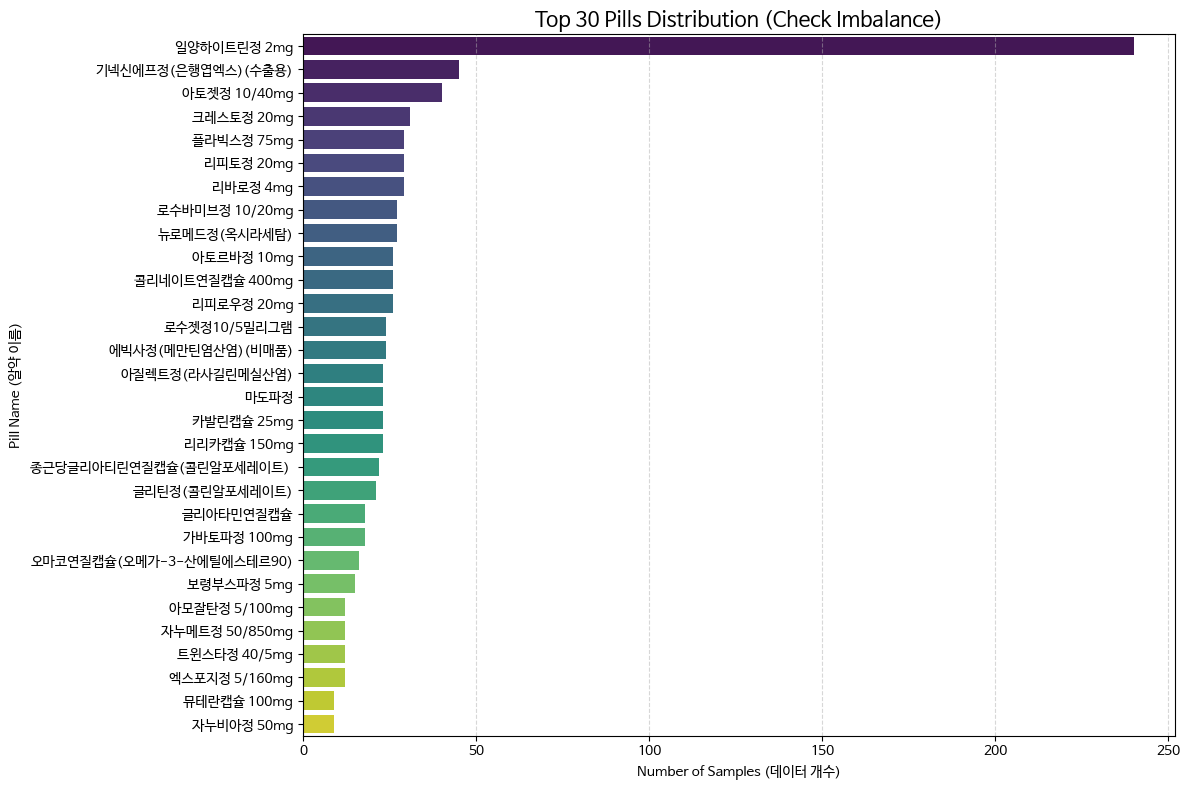

📊 그래프 해석 팁:
1. 그래프가 완만하게 줄어들면: 데이터 밸런스가 좋은 편입니다.
2. 'L'자 처럼 급격히 줄어들면: 데이터 불균형이 심하므로, 적은 데이터는 증강(Augmentation)이 필수입니다.


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# 시각화 설정
plt.figure(figsize=(12, 8))

# 막대 그래프 그리기 (x: 개수, y: 약 이름)
sns.barplot(data=top30_df, y='pill_name', x='count', palette='viridis')

plt.title("Top 30 Pills Distribution (Check Imbalance)", fontsize=15)
plt.xlabel("Number of Samples (데이터 개수)")
plt.ylabel("Pill Name (알약 이름)")
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 그래프 출력
plt.tight_layout()
plt.show()

print("📊 그래프 해석 팁:")
print("1. 그래프가 완만하게 줄어들면: 데이터 밸런스가 좋은 편입니다.")
print("2. 'L'자 처럼 급격히 줄어들면: 데이터 불균형이 심하므로, 적은 데이터는 증강(Augmentation)이 필수입니다.")

## **4. 데이터 전처리 & 데이터셋 구축**

### **4.1 데이터 클리닝**
- 유령 데이터(이미지 파일이 없는 경우)를 JSON에서 영구 제거하고 train_finam.json 생성

In [16]:
import os
import json

def clean_and_update_config():
    print("데이터 클리닝 시작...")

    # 1. 기존 JSON 로드
    with open(Config.TRAIN_JSON, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 2. 실제 파일 목록 스캔
    existing_files = set(os.listdir(Config.TRAIN_IMG_DIR))
    print(f"   📂 폴더 내 실제 파일 수: {len(existing_files)}개")

    # 3. 유효 데이터 필터링
    valid_images = []
    valid_img_ids = set()

    for img in data['images']:
        if img['file_name'] in existing_files:
            valid_images.append(img)
            valid_img_ids.add(img['id'])

    # 이미지 ID가 살아남은 경우만 어노테이션도 유지
    valid_annotations = [ann for ann in data['annotations'] if ann['image_id'] in valid_img_ids]

    # 4. 결과 저장
    cleaned_data = {
        "images": valid_images,
        "annotations": valid_annotations,
        "categories": data['categories']
    }

    # 새로운 파일명으로 저장 (덮어쓰기 방지)
    clean_path = os.path.join(Config.DATA_ROOT, 'train_final.json')
    with open(clean_path, 'w', encoding='utf-8') as f:
        json.dump(cleaned_data, f, ensure_ascii=False)

    # 5. Config 경로 영구 업데이트
    Config.TRAIN_JSON = clean_path

    print(f"   ✨ 클리닝 완료! 제거된 유령 데이터: {len(data['images']) - len(valid_images)}건")
    print(f"   ✅ 최종 학습 데이터 경로 업데이트: {Config.TRAIN_JSON}")

# 실행
if os.path.exists(Config.TRAIN_JSON):
    clean_and_update_config()
else:
    print("❌ train.json이 없습니다. 2.4단계를 확인하세요.")

데이터 클리닝 시작...
   📂 폴더 내 실제 파일 수: 651개
   ✨ 클리닝 완료! 제거된 유령 데이터: 137건
   ✅ 최종 학습 데이터 경로 업데이트: ./data/train_final.json


### **4.2 전처리 전략 수립**
- 약 봉지 상황 대응
- 약 봉지 속 알약 상황 구현을 위해서는 바운딩 박스도 같이 회전해야 함. 그래서 Albumentation 라이브러리로 해결.

In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 1. 학습용 (Train): 약 봉지 시뮬레이션 완결판
train_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),

    # (1) 회전: 봉지 안에서 굴러다님
    A.Rotate(limit=180, p=0.7),

    # (2) 반전: 앞뒤 구분 모호함
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    # (3) [New] 비닐 질감 시뮬레이션 ⭐
    # Blur: 비닐 때문에 뿌옇게 보이는 현상
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    # CLAHE: 비닐 난반사로 인한 국소적 대비 변화
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),

    # (4) 조명 변화 (기존 유지)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),

    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

# 2. 검증용 (Valid): 원본 유지
val_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']))

### **4.3 데이터셋 및 로더 구현**
- 데이터 수가 너무 적어서 9:1로 구현

In [31]:
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset

# 1. Dataset 클래스 정의
class PillDataset(Dataset):
    def __init__(self, json_path, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        with open(json_path, 'r') as f:
            self.coco = json.load(f)
        self.img_id_to_ann = {}
        for ann in self.coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.img_id_to_ann: self.img_id_to_ann[img_id] = []
            self.img_id_to_ann[img_id].append(ann)
        self.images = self.coco['images']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        file_name = img_info['file_name']
        img_id = img_info['id']
        img_path = os.path.join(self.img_dir, file_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        anns = self.img_id_to_ann.get(img_id, [])
        boxes, category_ids = [], []
        for ann in anns:
            x, y, w, h = ann['bbox']
            if w > 1 and h > 1:
                boxes.append([x, y, w, h])
                category_ids.append(ann['category_id'])

        if self.transform:
            transformed = self.transform(image=image, bboxes=boxes, category_ids=category_ids)
            image_tensor = transformed['image']
            boxes = transformed['bboxes']
            category_ids = transformed['category_ids']
        else:
            image_tensor = ToTensorV2()(image=image)['image']

        target = {}
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            # COCO(xywh) -> Pascal VOC(xyxy) 변환
            boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
            boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
            target['boxes'] = boxes
            target['labels'] = torch.tensor(category_ids, dtype=torch.int64)
        else:
            target['boxes'] = torch.zeros((0, 4), dtype=torch.float32)
            target['labels'] = torch.zeros((0), dtype=torch.int64)

        target['image_id'] = torch.tensor([img_id])
        return image_tensor, target

def collate_fn(batch): return tuple(zip(*batch))

# 2. 데이터 분할 및 로더 생성 (9:1)
print("데이터 로더 생성 중...")
full_dataset = PillDataset(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR)
indices = torch.randperm(len(full_dataset)).tolist()

train_size = int(len(full_dataset) * 0.9)
train_indices = indices[:train_size]
valid_indices = indices[train_size:]

train_dataset = Subset(PillDataset(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR, transform=train_transform), train_indices)
valid_dataset = Subset(PillDataset(Config.TRAIN_JSON, Config.TRAIN_IMG_DIR, transform=val_transform), valid_indices)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, collate_fn=collate_fn)

print(f"생성 완료: Train({len(train_dataset)}장), Valid({len(valid_dataset)}장)")

데이터 로더 생성 중...
생성 완료: Train(208장), Valid(24장)


### **4.4 파이프라인 최종 검증**

파이프라인 최종 검증


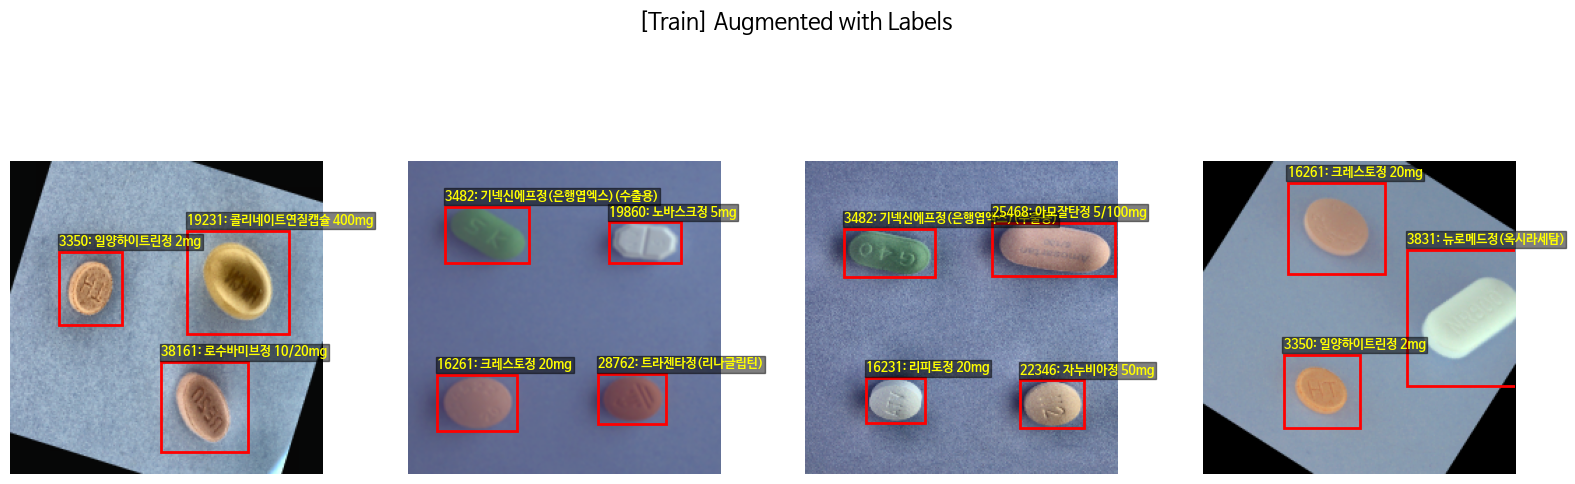

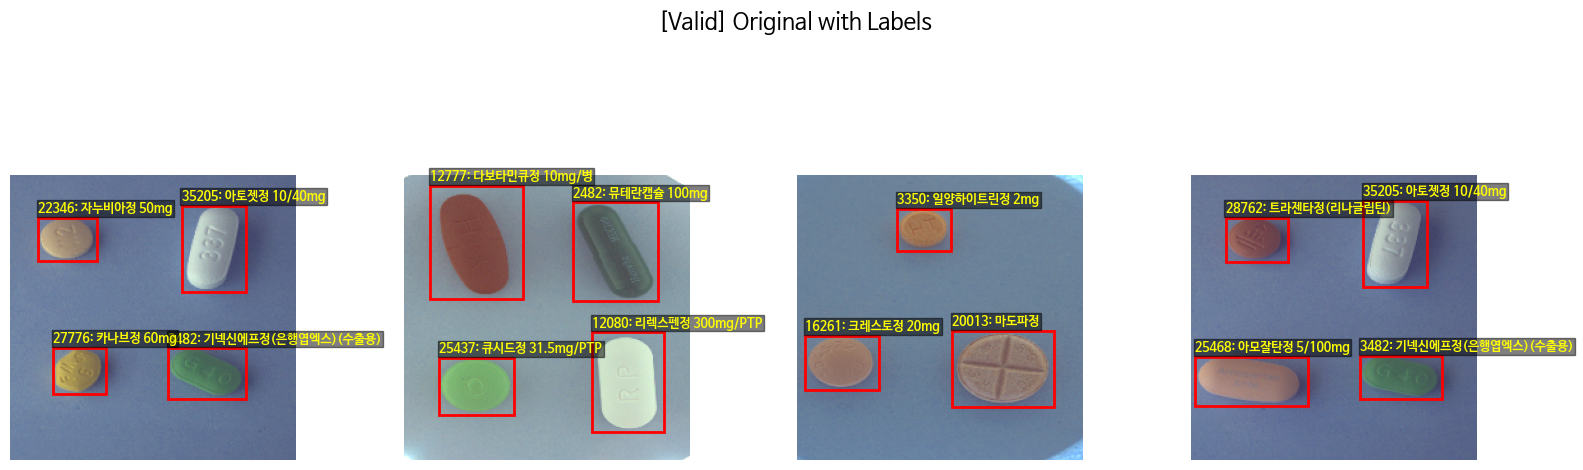

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

# 1. 약 이름 매핑 정보 로드 (이름을 띄우기 위해)
with open(Config.TRAIN_JSON, 'r', encoding='utf-8') as f:
    data = json.load(f)
    # ID -> Name 매핑 사전 생성
    id_to_name = {cat['id']: cat['name'] for cat in data['categories']}

# 2. 시각화 함수
def visualize_check_with_labels(loader, title):
    try:
        images, targets = next(iter(loader))
    except StopIteration:
        print("❌ 로더가 비어있습니다.")
        return

    plt.figure(figsize=(16, 6))

    # 4장만 샘플링
    for i in range(min(4, len(images))):
        # 이미지 역정규화
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(img)

        if 'boxes' in targets[i] and len(targets[i]['boxes']) > 0:
            for j, box in enumerate(targets[i]['boxes']):
                x1, y1, x2, y2 = box.numpy()
                class_id = targets[i]['labels'][j].item()
                pill_name = id_to_name.get(class_id, "Unknown")

                # (1) 빨간 박스
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

                # (2) 텍스트 라벨 (ID + 이름)
                # 글자가 잘 보이게 검은 배경에 노란 글씨로 출력
                label_text = f"{class_id}: {pill_name}"
                plt.text(x1, y1-5, label_text, color='yellow', fontsize=9, fontweight='bold',
                         bbox=dict(facecolor='black', alpha=0.5, pad=1))

        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# 실행
print("파이프라인 최종 검증")
visualize_check_with_labels(train_loader, "[Train] Augmented with Labels")
visualize_check_with_labels(valid_loader, "[Valid] Original with Labels")

## **5. 모델 구축 및 학습**

### **5.1 모델 선정**

### **5.2 학습 루프 구현 및 실행**

## **6. 모델 학습**

## **7. 결론 및 정리**